<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/W2D4/tutorials/W2D4_OptimalControl/W2D4_Tutorial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neuromatch Academy: Week 2, Day 4, Tutorial 1
# Optimal Control for Discrete States and Actions

**Tutorial Lecturer:** *Xaq Pitkow*

**Tutorial Content Creator:** *Zhengwei Wu*

## Tutorial objectives

In this tutorial, we will implement a binary control task: a Partially Observable Markov Decision Process (POMDP) that describes fishing. The agent (you) seeks reward from two fishing sites without directly observing where the school of fish is (a group of fish is called a school!). This makes the world a Hidden Markov Model. Based on when and where you catch fish, you keep updating your belief about the fish location, _i.e._ the posterior of the fish given past observations. You should control your position to get the most fish while minimizing the cost of switching sides.

You've already learned about stochastic dynamics, latent states, and measurements. Now we introduce you to the new concepts of **control, utility, and policy**.

---
##Setup  
Please execute the cells below to initialize the notebook environment.


In [1]:
# imports

import numpy as np                 # import numpy
import scipy                       # import scipy
from scipy.linalg import inv       # import matrix inversion
import matplotlib.pyplot as plt    # import matplotlib
from ipywidgets import interact, fixed
import ipywidgets as widgets

%matplotlib inline
from IPython import display


In [2]:
#@title Helper functions

def plot_fish(fish_state, ax = None):
    """
    Plot the fish dynamics
    """
    T = len(fish_state)

    showlen = min(T, 200)
    startT = 0

    endT = startT + showlen
    showT = range(startT, endT)
    time_range = np.linspace(0, showlen - 1)

    if not ax:
        fig, ax = plt.subplots(1, 1, figsize=(12, 2))  
    ax.plot(fish_state[showT], color='dodgerblue', markersize=10, linewidth=3.0)
    ax.set_xlabel('time', fontsize=18)
    ax.set_ylabel('Fish state', rotation=360, fontsize=18)
    ax.yaxis.set_label_coords(-0.1, 0.25)
    ax.set_xticks([0, showlen, showlen])
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.set_xlim([0, showlen])
    ax.set_ylim([-1.1, 1.1])
    ax.set_yticks([-1, 1])
    ax.tick_params(axis='both', which='major', labelsize=18)
    labels = [item.get_text() for item in ax.get_yticklabels()]
    labels[1] = 'Right'
    labels[0] = 'Left'
    ax.set_yticklabels(labels)

def plot_measurement(measurement, ax = None):
    """
    Plot the measurements
    """
    T = len(measurement)

    showlen = min(T, 200)
    startT = 0
    endT = startT + showlen
    showT = range(startT, endT)
    time_range = np.linspace(0, showlen - 1)

    if not ax:
        fig, ax = plt.subplots(1, 1, figsize=(12, 2))
    ax.plot(measurement[showT], 'r*', markersize=5)
    ax.set_xlabel('time', fontsize=18)
    ax.set_ylabel('Measurement', rotation=360, fontsize=18)
    ax.yaxis.set_label_coords(-0.2, 0.4)
    ax.set_xticks([0, showlen, showlen])
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.set_xlim([0, showlen])
    ax.set_ylim([-.1, 1.1])
    ax.set_yticks([0, 1])
    ax.set_yticklabels(['no fish','caught fish'])

def plot_act_loc(loc, act, ax_loc = None):
    """
    Plot the action and location of 200 time points
    """
    T = len(act)

    showlen = min(T, 200)
    startT = 0

    endT = startT + showlen
    showT = range(startT, endT)
    time_range = np.linspace(0, showlen - 1)

    if not ax_loc:
        fig, ax_loc = plt.subplots(1, 1, figsize=(12, 2))

    act_int = (act == "switch" ).astype(int)
    ax_loc.plot(loc[showT], 'g.-', markersize=8, linewidth=5)
    ax_loc.plot((act_int[showT] * 4 - 3) * .5, 'rv', markersize=12, label = 'switch')
    ax_loc.set_xlabel('time', fontsize=18)
    ax_loc.set_ylabel('Your state', rotation=360, fontsize=18)
    
    ax_loc.legend(loc="upper right", fontsize = 12)
    ax_loc.set_xlim([0, showlen])
    ax_loc.set_ylim([-1.1, 1.1])
    ax_loc.set_yticks([-1, 1])
    ax_loc.set_xticks([0, showlen, showlen])
    ax_loc.tick_params(axis='both', which='major', labelsize=18)
    labels = [item.get_text() for item in ax_loc.get_yticklabels()]
    labels[0] = 'Left'
    labels[1] = 'Right'
    ax_loc.set_yticklabels(labels)

def plot_belief(belief, ax1 = None, choose_policy = None):
    """
    Plot the belief dynamics of 200 time points
    """

    T = belief.shape[1]

    showlen = min(T, 200)
    startT = 0

    endT = startT + showlen
    showT = range(startT, endT)
    time_range = np.linspace(0, showlen - 1)

    if not ax1:
        fig, ax1 = plt.subplots(1, 1, figsize=(12, 2))

    ax1.plot(belief[0, showT], color='dodgerblue', markersize=10, linewidth=3.0)
    ax1.yaxis.set_label_coords(-0.1, 0.25)
    ax1.set_xlabel('time', rotation=360, fontsize=18)
    ax1.set_ylabel('Belief on \n left', rotation=360, fontsize=18)
    ax1.tick_params(axis='both', which='major', labelsize=18)
    ax1.set_xlim([0, showlen])
    ax1.set_yticks([0, 1])
    ax1.set_ylim([0, 1.1])
    ax1.set_xticks([0, showlen, showlen])

    if choose_policy == "threshold":
        ax2 = ax1.twinx()
        ax2.plot(time_range, threshold * np.ones(time_range.shape), 'r--')
        ax2.plot(time_range, (1 - threshold) * np.ones(time_range.shape), 'c--')
        ax2.set_yticks([threshold, 1 - threshold])
        ax2.set_ylim([0, 1.1])
        ax2.tick_params(axis='both', which='major', labelsize=18)
        labels = [item.get_text() for item in ax2.get_yticklabels()]
        labels[0] = 'threshold to switch \n from left to right'
        labels[-1] = 'threshold to switch \n from right to left'
        ax2.set_yticklabels(labels)

def plot_dynamics(belief, loc, act, meas, fish_state, choose_policy):
    """
    Plot the dynamics of 200 time points
    """
    if choose_policy == 'threshold':
        fig, [ax0, ax_loc, ax1, ax_bel] = plt.subplots(4, 1, figsize=(12, 9))
        plot_fish(fish_state, ax = ax0)
        plot_act_loc(loc, act, ax_loc = ax_loc)
        plot_measurement(measurement, ax = ax1)
        plot_belief(belief, ax1 = ax_bel)
    else:
        fig, [ax0, ax1, ax_bel] = plt.subplots(3, 1, figsize=(12, 7))
        plot_fish(fish_state, ax = ax0)
        plot_measurement(measurement, ax = ax1)
        plot_belief(belief, ax1 = ax_bel)

    plt.tight_layout()
    plt.show()

def belief_histogram(belief, bins = 100):
    """
    Plot the histogram of belief states
    """
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.hist(belief, bins)
    ax.set_xlabel('belief', fontsize = 18)
    ax.set_ylabel('count', fontsize = 18)
    plt.show()

def plot_value_threshold(cost_sw, T, p_stay, 
                         rew_probability_high, rew_probability_low, step = 0.05):
    """
    Helper function to plot the value function and threshold 
    """
    params = [T, p_stay, rew_probability_high, rew_probability_low, _]
        
    threshold_array, value_array = value_threshold(params, cost_sw, step)

    fig_, ax = plt.subplots(1, 1, figsize=(6, 6))
    ax.plot(threshold_array, value_array, 'b')
    ax.set_ylim([np.min(value_array), np.max(value_array)])
    ax.set_title('threshold vs value with switching cost c = %.2f'%cost_sw, fontsize = 20)
    ax.set_xlabel('threshold', fontsize = 16)
    ax.set_ylabel('value', fontsize = 16)
    plt.show()


---
## 1. Dynamics of Fishing

Video available at https://youtube.com/watch?v=93yl87TlVnY


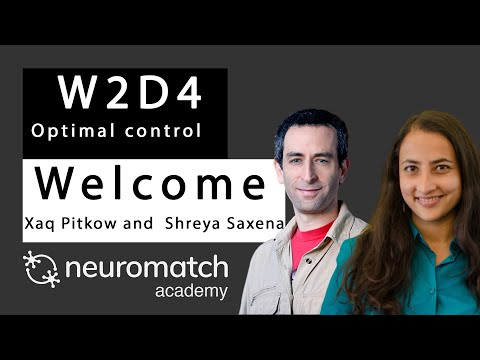

In [3]:
#@title Video: Gone fishing
from IPython.display import YouTubeVideo
video = YouTubeVideo(id='93yl87TlVnY', width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video


### Task Description

There are two locations for the fish and you (Left and Right). If you're on the same side as the fish, you'll catch more, with probabilty $q_{\rm high}$ per discrete time step. Otherwise you may still catch fish with probability $q_{\rm low}$. One fish is worth 1 "point".

The fish location $s^{\rm fish}$ is latent. The only information you get about the fish location is when you catch one. Secretly at each time step, the fish may switch sides with a certain probability $p_{\rm sw} = 1 - p_{\rm stay}$.


You are in control of your own location. You may stay on your current side with no cost, or switch to the other side and incur an action cost $C$ (again, in units of fish).

You select controls or actions by following a **policy**. This defines what to do in any situation. Here the situation is specified by your location and your belief $b_t$ about the fish location. For optimal control we assume that this belief is the posterior probability over the current fish location, given all the past measurements. We only need one number for this, since the fish are either on the left or the right. So we write 

$$b_t = p(s^{\rm fish}_t = {\rm Right}\  |\  m_{0:t}, a_{0:t-1})$$

where $m$ are the measurements, and $a$ are the controls or actions (stay or switch).

Ultimately we will parameterize the policy by a simple threshold on beliefs. (This happens to be optimal if you pick the right threshold!) When your belief that fish are on your current side falls below a threshold $\theta$, you switch to the other side.

Your **overall goals** in this tutorial are:
1. Measure when fish are caught, first if the school of fish doesn't move.
2. For moving fish, plot their dynamics and your belief about it based on your measurements.
3. Compute the value for a given control policy.
4. Find the optimal policy for controlling your position.

### Exercise 1.1
Evaluate the following helper code.

In [4]:
# class for the binary HMM task

class binaryHMM():

    def __init__(self, params, fish_initial = -1, loc_initial = -1):
        self.params = params
        self.fish_initial = fish_initial
        self.loc_initial = loc_initial

    def fish_state_telegraph(self, fish_past, p_stay):
        """
        fish state update according to telegraph process

        Parameters
        ----------
        fish_past (int): the fish location (-1 for left side, 1 for right side)
        p_stay : the probability that the state of a certain site stays the same

        Returns
        -------
        fish_new (int): updated fish location
        """

        fish_new = (1 - np.random.binomial(1, p_stay)) ^ ((fish_past + 1) // 2)   # ^ is XOR
        fish_new = fish_new * 2 - 1
        
        return fish_new


    def fish_dynamics(self):
        """
        fish state dynamics according to telegraph process
  
        Returns
        -------
        fish_state (numpy array of int)
        """
        T, p_stay, rew_probability_high, rew_probability_low, threshold = self.params
        fish_state = np.zeros(T, int)  # -1: left side ; 1: right side

        # initialization 
        fish_state[0] = self.fish_initial

        for t in range(1, T):
            fish_state[t] = self.fish_state_telegraph(fish_state[t-1], p_stay)
        
        return fish_state


    def generate_process_lazy(self):
        """
        fish dynamics and measurements if you always stay in the intial location without changing sides

        Returns
        -------
        fish_state (numpy array of int): locations of the fish
        loc (numpy array of int): left or right site, -1 for left, and 1 for right
        measurement (numpy array of binary): whether a reward is obtained
        """

        T, p_stay, rew_probability_high, rew_probability_low, threshold = self.params
        rp = np.array([rew_probability_low, rew_probability_high])

        fish_state = self.fish_dynamics()
        loc  = np.zeros(T, int)                      # -1: left side, 1: right side
        measurement = np.zeros(T, int)               # 0: no food, 1: get food

        loc[0] = self.loc_initial
        measurement[0] = 0

        for t in range(1, T):
            loc[t] = loc[t - 1]
            # new measurement
            measurement[t] = np.random.binomial(1, rp[(fish_state[t] == loc[t]) * 1])

        return fish_state, loc, measurement


### Execise 1.2

Run the following code to see the dynamics of the fish as they follow the telegraph process.

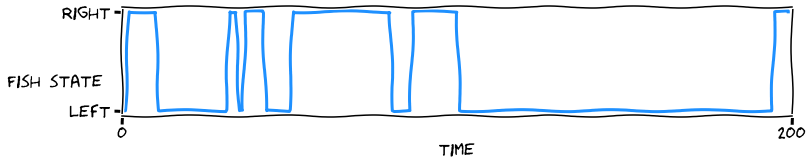

In [5]:
T = 200
p_stay = .95     # probability fish stay
rew_probability_high = .4    # p(catch fish) when you're on their side
rew_probability_low = .1     # p(catch fish) when you're on other side

params = [T, p_stay, rew_probability_high, rew_probability_low, _]

binaryHMM_test = binaryHMM(params)

fish_state = binaryHMM_test.fish_dynamics()
with plt.xkcd():
    plot_fish(fish_state)


---
## 2. Catch some fish on each side

Video available at https://youtube.com/watch?v=eizoUa__o7w


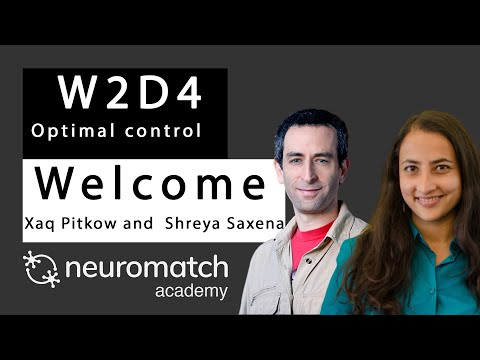

In [6]:
#@title Video: Catch some fish
video = YouTubeVideo(id='eizoUa__o7w', width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

### Exercise 2

Now set $p_{\rm stay} = 1$ so that the state of the two sites are fixed, and we can directly see the chances of catching fish on each side. The variable `fish_initial` indicates the initial side of the fish, and `loc_initial` indicates your initial location. They each take value $-1$ for left and $1$ for right.

**Instructions:**
1. set the two locations to be the _same_, and measure when you catch fish
2. set the locations to be _different_, and measure when you catch fish
3. visually compare the measurements from 1 and 2.

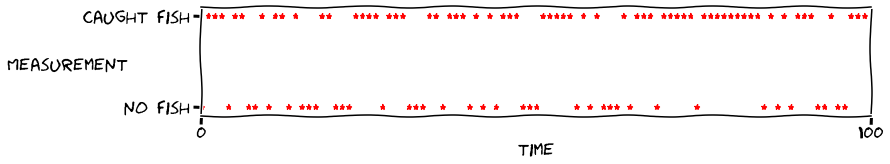

In [7]:
T = 100

p_stay = 1      # probability fish stay
rew_probability_high = .6    # p(catch fish) when you're on their side
rew_probability_low = .05     # p(catch fish) when you're on other side

params = [T, p_stay, rew_probability_high, rew_probability_low, _]

binaryHMM_test = binaryHMM(params, fish_initial= -1, loc_initial = -1)

fish_state, loc, measurement = binaryHMM_test.generate_process_lazy()

with plt.xkcd():
    plot_measurement(measurement)


---
## 3. Belief dynamics and belief distributions

Video available at https://youtube.com/watch?v=14u5egBysTs


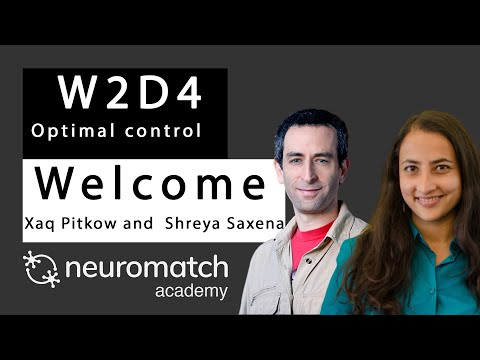

In [8]:
#@title Video: Where are the fish?
video = YouTubeVideo(id='14u5egBysTs', width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

###Exercise 3.1: Plot belief dynamics and belief distributions

We have provided a class for the binary task, with the agent always staying at one side following a lazy policy function `def policy_lazy(belief, loc)` that we provided. Now in this exercise, you will extend the module to generate the real dynamics, including beliefs and a moving agent. With the generated data, we will see how beliefs change over time, and how often different beliefs happen.

For convenience, your belief at time *t* is actually a 2-dimensional vector. The first element is the belief that the fish are on the left, and the second element is the belief the fish are on the right. At every time, these elements sum to $1$.

We will first check the dynamics with lazy policy, and then explore the case with a threshold-based policy.

**Instructions:**
Evaluate the cells below to setup the lazy policy.


In [9]:
# class for binary HMM task with policy

class binaryHMM_belief(binaryHMM):

    def __init__(self, params, fish_initial = -1, loc_initial = -1, choose_policy = 'threshold'):
        binaryHMM.__init__(self, params, fish_initial, loc_initial)
        self.choose_policy = choose_policy

    def generate_process(self):  
        """
        fish dynamics and measurements based on the choosen policy

        Returns
        -------
        belief (numpy array of float): belief on the states of the two sites
        act (numpy array of string): actions over time
        loc (numpy array of int): left or right site
        measurement (numpy array of binary): whether a reward is obtained
        fish_state (numpy array of int): fish locations
        """
        
        T, p_stay, rew_probability_high, rew_probability_low, threshold = self.params
        fish_state = self.fish_dynamics()     # -1: left side; 1: right side
        loc  = np.zeros(T, int)               # -1: left side, 1: right side
        measurement = np.zeros(T, int)        # 0: no food, 1: get food
        act  = np.empty(T, dtype='object')    # "stay", or "switch" 
        belief = np.zeros((2, T), float)      # the probability that the fish is on the left (1st element) 
                                              # or on the right (2nd element),
                                              # the beliefs on the two boxes sum up to be 1

        rew_prob = np.array([rew_probability_low, rew_probability_high]) 

        #initialization 
        loc[0] = -1
        measurement[0] = 0
        belief_0 = np.random.random(1)[0]
        belief[:, 0] = np.array([belief_0, 1 - belief_0])
        act[0] = self.policy(threshold, belief[:, 0], loc[0])       

        for t in range(1, T):
            if act[t - 1] == "stay":
                loc[t] = loc[t - 1]
            else:  
                loc[t] = - loc[t - 1]

            # new measurement
            measurement[t] = np.random.binomial(1, rew_prob[(fish_state[t] == loc[t]) * 1])
            belief[0, t] = self.belief_update(belief[0, t - 1] , loc[t], 
                                                measurement[t], p_stay)
            belief[1, t] = 1 - belief[0, t]

            act[t] = self.policy(threshold, belief[:, t], loc[t])

        return belief, loc, act, measurement, fish_state


    def policy(self, threshold, belief, loc):
        """
        chooses policy based on whether it is lazy policy or a threshold-based policy

        Parameters
        ----------
        threshold (float): the threshold of belief on the current site, 
                           when the belief is lower than the threshold, switch side 
        belief (numpy array of float): the belief on the two sites
        loc (int) : the location of the agent

        Returns
        -------
        act (string): "stay" or ""switch
        """

        if self.choose_policy == "threshold":
            act = policy_threshold(threshold, belief, loc)
        if self.choose_policy == "lazy":
            act = policy_lazy(belief, loc)
        
        return act


    def belief_update(self, belief_past, loc, measurement, p_stay):
        """
        using PAST belief on the LEFT box, CURRENT location and measurement to update belief
        """
        rew_prob_matrix = np.array([[1 - rew_probability_high, rew_probability_high], 
                           [1 - rew_probability_low, rew_probability_low]])
        
        # update belief posterior, p(s[t] | measurement(0-t), act(0-t-1))
        belief_0 = (belief_past * p_stay  + (1 - belief_past) * (1 - p_stay)) * rew_prob_matrix[ (loc + 1 ) // 2, measurement]
        belief_1 = ((1 - belief_past) * p_stay + belief_past * (1 - p_stay)) * rew_prob_matrix[1-(loc + 1 ) // 2, measurement]

        belief_0 = belief_0 / (belief_0 + belief_1)

        return belief_0


In [10]:
def policy_lazy(belief, loc):
    """
    This function is a lazy policy where stay is also taken
    """
    act = "stay"
    return act


### Exercise 3.2: Task dynamics following a **lazy** policy

The parameter for policy `choose_policy` can be either "*lazy*" or "*threshold*". In the following example, use the lazy policy.

**Instructions:**
* With the class defined above, first create an object of `binaryHMM_belief` given parameters of the dynamics, *params*, and a parameter for policy.
* Then simply run the dynamics and explain the time series of the beliefs you see.


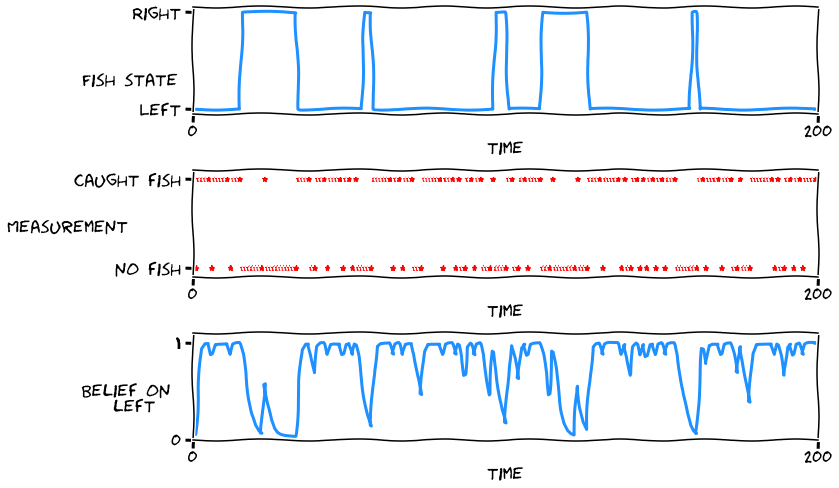

In [11]:
T = 400

p_stay = .95     # probability fish stay
rp_high = .4    # p(catch fish) when you're on their side
rp_low = .1     # p(catch fish) when you're on other side

threshold = .2    # threshold of belief below which switching is taken

params = [T, p_stay, rew_probability_high, rew_probability_low, threshold]

binaryHMM_test = binaryHMM_belief(params, fish_initial = -1, loc_initial = -1,
                                  choose_policy="lazy")

# Plot the dynamics of the binaryHMM task
belief, loc, act, measurement, fish_state = binaryHMM_test.generate_process()
with plt.xkcd():
    plot_dynamics(belief, loc, act, measurement,
                  fish_state, binaryHMM_test.choose_policy)


---
## 4. Implementing threshold policy

Video available at https://youtube.com/watch?v=oizt8Wtia5Y


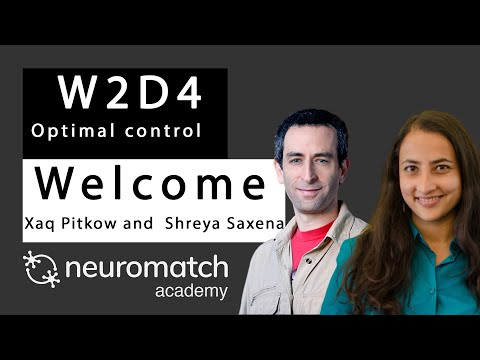

In [12]:
#@title Video: How should you act?
video = YouTubeVideo(id='oizt8Wtia5Y', width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

### Exercise 4: dynamics following a **threshold-based** policy.

**Instructions:**

* You need to code a new policy `def policy_threshold(threshold, belief, loc)`. The policy takes three inputs: your belief about the fish state, your location ("Left" or "Right"), and a belief _threshold_: when your belief that you are on the same side as the fish drops below this threshold, you choose to switch; otherwise you stay.

* You should return an action for each time *t*, which takes the value of "stay" or "switch".

* After you complete the code for the policy based on threshold, create an object of `binaryHMM_belief` and set the policy parameter to be `choose_policy = threshold`.
* We have provided an example of the parameters. You should play with the parameters to see the various dynamics.

In [13]:
# Complete the policy_threshold function

def policy_threshold(threshold, belief, loc):
    """
    chooses whether to switch side based on whether the belief on the current site drops below the threshold

    Parameters
    ----------
    threshold (float): the threshold of belief on the current site, 
                        when the belief is lower than the threshold, switch side 
    belief (numpy array of float, 2-dimensional): the belief on the two sites at a certain time
    loc (int) : the location of the agent at a certain time
                -1 for left side and 1 for right side

    Returns
    -------
    act (string): "stay" or ""switch
    """
    ###############################################################################
    ## Insert code to:
    ## generate actions (Stay or Switch) for current belief and location
    ##
    ## Belief is a 2d vector: first element = Prob( fish on Right | measurements )
    ##                       second element = Prob( fish on Left  | measurements )
    ## Returns "switch" if Belief that fish are in your current location < threshold
    ##         "stay" otherwise
    ##
    ## complete the function and remove
    raise NotImplementedError("Student exercise: Please complete <act>")
    ###############################################################################
    # act = ...

    return act


In [14]:
# to_remove solution

def policy_threshold(threshold, belief, loc):
    """
    chooses whether to switch side based on whether the belief on the current site drops below the threshold

    Parameters
    ----------
    threshold (float): the threshold of belief on the current site, 
                        when the belief is lower than the threshold, switch side 
    belief (numpy array of float, 2-dimensional): the belief on the two sites at a certain time
    loc (int) : the location of the agent at a certain time
                -1 for left side, 1 for right side

    Returns
    -------
    act (string): "stay" or ""switch
    """

    if belief[(loc + 1 ) // 2]  <= threshold:
        act = "switch"
    else:
        act = "stay"

    return act
  
def policy_lazy(belief, loc):
    """
    This function is a lazy policy where stay is also taken
    """
    act = "stay"

    return act


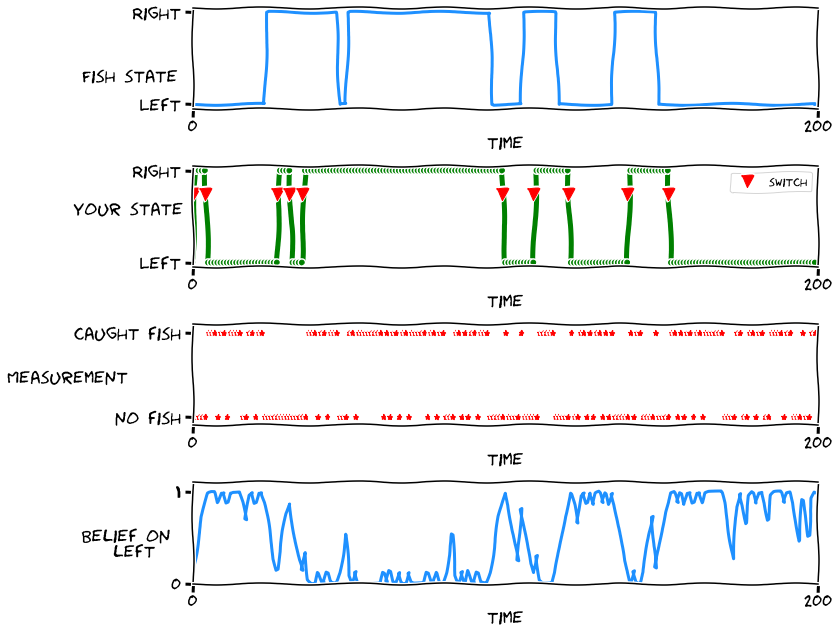

In [15]:
T = 400

p_stay = .95     # probability fish stay
rp_high = .4    # p(catch fish) when you're on their side
rp_low = .1     # p(catch fish) when you're on other side

threshold = .2    # threshold of belief below which switching is taken

params = [T, p_stay, rew_probability_high, rew_probability_low, threshold]

binaryHMM_test = binaryHMM_belief(params, fish_initial = -1, loc_initial = -1,
                                  choose_policy="threshold")


# Plot the dynamics of the binaryHMM task
belief, loc, act, measurement, fish_state = binaryHMM_test.generate_process()
with plt.xkcd():
    plot_dynamics(belief, loc, act, measurement,
                  fish_state, binaryHMM_test.choose_policy)


---
## 5. Implementing Value function

Video available at https://youtube.com/watch?v=GYjBvYXW_IA


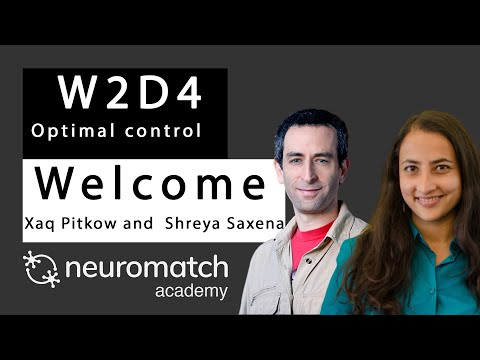

In [16]:
#@title Video: Evaluate policy
video = YouTubeVideo(id='GYjBvYXW_IA', width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

###Exercise 5
Now we have generated behavior for a policy parameterized by a threshold. While it seems clear that this is at least better than being lazy, we want to know how good it is. For that, we will calculate a _value function_. We will use this value to compare different policies, and maximize the amount of fish we catch while minimizing our effort. 

Specifically, here the value is total expected utility per unit time.

$$V(\theta) = \frac{1}{T}\left(\sum_t U_s(s_t) + U_a(a_t)\right)$$ 

where $U_s(s_t)$ is the instantaneous utility (reward) from the site, and $U_a(a_t)$ is the utility (negative cost) for the chosen action. Here, the action cost is 0 if you stay, and `cost_sw` if you switch. 

We could take this average mathematically over the probabilities of rewards and actions. More simply, we get the same answer by simply averaging the _actual_ rewards and costs over a long time, so that's what you should do.


**Instructions**
* Fill in the function `value_function(measurement, act, cost_sw)` given a sequence of measurements, actions, and the cost of switching.
* Visually find the threshold that yields the highest total value. We have provided code for plotting value versus threshold. The threshold $\theta^*$ with the highest value gives the optimal policy for controlling where you should fish.

In [17]:
# complete the value_function

def value_function(measurement, act, cost_sw):
    """
    value function 
    """
    act_int = (act == "switch" ).astype(int)       # convert labels to binary
    T = len(measurement)   

    ###############################################################################
    ## Insert your code here to:
    ##        compute the value function
    ##
    ## complete the function and remove
    raise NotImplementedError("Student exercise: Please complete <value>")
    ###############################################################################

    #value = ...     # rate of catching fish - costs

    return value


In [18]:
# to_remove solution

def value_function(measurement, act, cost_sw):
    """
    value function 
    """
    act_int = (act == "switch" ).astype(int)       # convert labels to binary
    T = len(measurement)   

    value = (np.sum(measurement) - np.sum(act_int) * cost_sw) / T     # rate of catching fish - costs

    return value


In [19]:
# Brute force search for optimal policy: loop over thresholds and compute value for each.
# This function is needed for the second exercise.

def value_threshold(params, cost_sw, step):
    threshold_array = np.arange(0, 1 + step, step)
    value_array = np.zeros(threshold_array.shape)
    
    T, p_stay, rew_probability_high, rew_probability_low, _ = params
    
    for i in range(len(threshold_array)):
        threshold = threshold_array[i]
        
        params = [T, p_stay, rew_probability_high, rew_probability_low, threshold]
        binaryHMM_test = binaryHMM_belief(params, choose_policy="threshold")
        belief, loc, act, measurement, fish_state = binaryHMM_test.generate_process()
        
        value_array[i] = value_function(measurement, act, cost_sw)
    
    return threshold_array, value_array


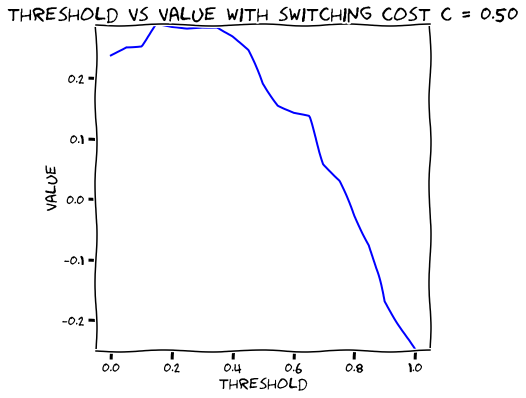

In [20]:
T = 10000
p_stay = .95          # state transiton probability
rew_probability_high = .4
rew_probability_low = .1

cost_sw = .5

with plt.xkcd():
    plot_value_threshold(cost_sw, T, p_stay, rew_probability_high, rew_probability_low)


---
## 6. (Optional) Different task, different optimal policy

Video available at https://youtube.com/watch?v=kVSgbA_i-ns


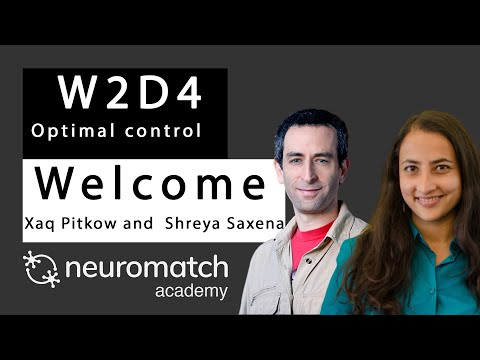

In [21]:
#@title Video: Sensitivity of optimal policy
video = YouTubeVideo(id='kVSgbA_i-ns', width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)
video

### Exercise 6
This is a thinking exercise.

**Instructions:**
After plotting value versus threshold, adjust various task parameters using the sliders below, and observe how the optimal threshold moves with
* switching cost (`cost_sw`)
* fish dynamics (`p_switch`)
* probability of catching fish on each side, `rew_probability_low` and `rew_probability_high`

Can you explain why the optimal threshold changes with these parameters?






In [22]:
#@title Interactive task
_ = interact(plot_value_threshold,
             cost_sw = (0, 2,.2), 
             T = fixed(T),
             p_stay = widgets.FloatSlider(min=0., max=1., step=0.05, value=p_stay),
             rew_probability_high = widgets.FloatSlider(min=0., max=1., step=0.1, value=rew_probability_high),
             rew_probability_low = widgets.FloatSlider(min=0., max=1., step=0.1, value=rew_probability_low),
             step = fixed(0.05))


interactive(children=(FloatSlider(value=1.0, description='cost_sw', max=2.0, step=0.2), FloatSlider(value=0.95…

**Instructions:**

EXPLAIN why the optimal threshold changes for:
* lower switching cost?
* faster fish dynamics?
* rarer fish?